In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
from MDAnalysis.analysis.distances import dist
from tqdm import tqdm
import pandas as pd
import pickle
import red

/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def getDistance(idx1, idx2, u):
    """
    Get the distance between two atoms in a universe.

    Parameters
    ----------
    idx1 : int
        Index of the first atom
    idx2 : int
        Index of the second atom
    u : MDAnalysis.Universe
        The MDA universe containing the atoms and
        trajectory.

    Returns
    -------
    distance : float
        The distance between the two atoms in Angstroms.
    """
    distance = dist(
        mda.AtomGroup([u.atoms[idx1]]),
        mda.AtomGroup([u.atoms[idx2]]),
        box=u.dimensions,
    )[2][0]
    return distance

def closest_residue_to_point(atoms, point):
    """Find the closest residue in a selection of atoms to a given point"""
    residues = atoms.residues
    distances = np.array([np.linalg.norm(res.atoms.center_of_mass() - point) for res in residues])

    # Find the index of the smallest distance
    closest_residue_index = np.argmin(distances)

    # Return the closest residue
    return residues[closest_residue_index], distances[closest_residue_index]

def obtain_CA_idx(u, res_idx):
    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    selection_str = f"resid {res_idx} and name CA"
    
    selected_CA = u.select_atoms(selection_str)

    if len(selected_CA.indices) == 0 or selected_CA.indices[0] == None:
        print('CA not found for the specified residue...')
    
    elif len(selected_CA.indices) > 1:
        print('Multiple CAs found, uh oh...')

    else:  
        return selected_CA.indices[0]
    
def obtain_angle(pos1, pos2, pos3):

    return mda.lib.distances.calc_angles(pos1, pos2, pos3)

def obtain_dihedral(pos1, pos2, pos3, pos4):
    
    return mda.lib.distances.calc_dihedrals(pos1, pos2, pos3, pos4)
  
def obtain_RMSD(u, res_range):

    protein = u.select_atoms("protein")

    ref = protein
    R_u =rms.RMSD(protein, ref, select=f'backbone and resid {res_range[0]}-{res_range[1]}')
    R_u.run()

    rmsd_u = R_u.rmsd.T #take transpose
    time = rmsd_u[1]/1000
    rmsd= rmsd_u[2]

    return time, rmsd

### Plotting RMSD

Text(0.5, 0, 'Time')

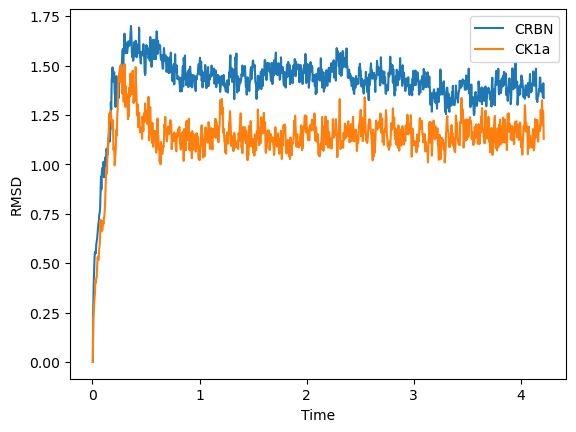

In [6]:
u = mda.Universe('../../structures/complex_eq.prmtop', 'sep_traj.dcd')
time_rec, rmsd_rec = obtain_RMSD(u, res_range=[0,312])
time_lig, rmsd_lig = obtain_RMSD(u, res_range=[314, 606])

plt.plot(time_rec, rmsd_rec, label='CRBN')
plt.plot(time_lig, rmsd_lig, label='CK1a')
plt.legend()
plt.ylabel('RMSD')
plt.xlabel('Time')

### Plotting Boresch DOFs

In [7]:
def obtain_Boresch_dof(u, dof):
    
    rec_interface_res =  [36, 37, 38, 39, 79, 80, 81, 127, 210, 212, 213, 214, 215, 216, 237, 238, 239, 240, 241, 242, 243, 244, 255, 256, 257, 258, 259, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 308] 
    lig_interface_res =  [317, 318, 319, 320, 338, 339, 340, 341, 342, 343, 344, 345, 346, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 393, 394, 395, 450, 451, 452]  

    res_b = 90
    res_c = 172
    res_B = 424
    res_C = 508

    group_a = u.atoms[[obtain_CA_idx(u, res) for res in rec_interface_res]]
    group_b = u.atoms[[obtain_CA_idx(u, res_b)]]
    group_c = u.atoms[[obtain_CA_idx(u, res_c)]]
    group_A = u.atoms[[obtain_CA_idx(u, res) for res in lig_interface_res]]
    group_B = u.atoms[[obtain_CA_idx(u, res_B)]]
    group_C = u.atoms[[obtain_CA_idx(u, res_C)]]

    pos_a = group_a.center_of_mass()
    pos_b = group_b.center_of_mass()
    pos_c = group_c.center_of_mass()
    
    pos_A = group_A.center_of_mass()
    pos_B = group_B.center_of_mass()
    pos_C = group_C.center_of_mass()

    dof_indices = {
        'thetaA' : [pos_b, pos_a, pos_A],
        'thetaB' : [pos_a, pos_A, pos_B],
        'phiA' : [pos_c, pos_b, pos_a, pos_A],
        'phiB': [pos_b, pos_a, pos_A, pos_B],
        'phiC': [pos_a, pos_A, pos_B, pos_C]
    }

    indices = dof_indices[dof]

    if len(indices) == 3:
        return obtain_angle(indices[0], indices[1], indices[2])

    else:
        return obtain_dihedral(indices[0], indices[1], indices[2], indices[3])


In [8]:
eq_vals = {'thetaA' : 2.3,
           'thetaB' : 2.3,
           'phiA' : 2.3,
           'phiB' : -2.7,
           'phiC' : 2.7}

In [9]:
u = mda.Universe('../../structures/complex_eq.prmtop', 'sep_traj.dcd')

dofs = eq_vals.keys()
dof_data = []

for dof in dofs:

    vals = []

    for ts in tqdm(u.trajectory, total=u.trajectory.n_frames, desc=f'{dof} analysis'):
        vals.append(obtain_Boresch_dof(u, dof))
    
    dof_data.append(vals)
               

phiC analysis: 100%|██████████| 1101/1101 [02:15<00:00,  8.13it/s]


In [10]:
dofs = list(dofs)
frames = np.arange(1, len(dof_data[0]) + 1) 

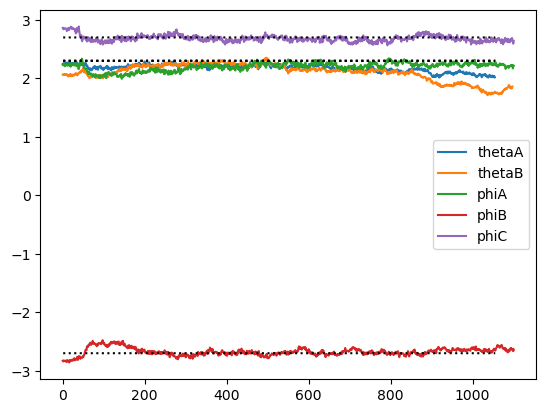

In [14]:
for n in range(len(dofs)):

    plt.plot(dof_data[n], label=dofs[n])

plt.plot(frames, eq_vals['thetaA']*np.ones(len(frames)), c='k', linestyle='dotted')
plt.plot(frames, eq_vals['thetaB']*np.ones(len(frames)), c='k', linestyle='dotted')
plt.plot(frames, eq_vals['phiA']*np.ones(len(frames)), c='k', linestyle='dotted')
plt.plot(frames, eq_vals['phiB']*np.ones(len(frames)), c='k', linestyle='dotted')
plt.plot(frames, eq_vals['phiC']*np.ones(len(frames)), c='k', linestyle='dotted')

plt.legend()

### Testing anchor points

In [19]:
u = mda.Universe('../../structures/complex.prmtop', 'sep_traj.dcd')

rec_interface_res =  [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 32, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 58, 118, 119, 120, 121, 122, 123, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 156]
lig_interface_res =  [190, 191, 192, 193, 208, 209, 210, 211, 214, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 364, 365, 366, 368, 369, 370, 371, 372, 374]

res_b = 8
res_c = 142
res_B = 332
res_C = 244

group_a = u.atoms[[obtain_CA_idx(u, res) for res in rec_interface_res]]
group_b = u.atoms[[obtain_CA_idx(u, res_b)]]
group_c = u.atoms[[obtain_CA_idx(u, res_c)]]
group_A = u.atoms[[obtain_CA_idx(u, res) for res in lig_interface_res]]
group_B = u.atoms[[obtain_CA_idx(u, res_B)]]
group_C = u.atoms[[obtain_CA_idx(u, res_C)]]

pos_a = group_a.center_of_mass()
pos_b = group_b.center_of_mass()
pos_c = group_c.center_of_mass()
pos_A = group_A.center_of_mass()
pos_B = group_B.center_of_mass()
pos_C = group_C.center_of_mass()


/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)
/home/btan/miniconda3/envs/openbiosim/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### OpenMM testing

In [10]:
import numpy as np
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import sys
import os
import pandas as pd

"""System setup"""

dt = 4*unit.femtoseconds

# Load param and coord files
prmtop = app.AmberPrmtopFile('../../structures/complex.prmtop')
inpcrd = app.AmberInpcrdFile('../../structures/complex.inpcrd')

system = prmtop.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, hydrogenMass=1.5*unit.amu, constraints=app.HBonds)  
integrator = mm.LangevinMiddleIntegrator(300.0000*unit.kelvin, 1.0000/unit.picosecond, dt)

simulation = app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimise energy 
simulation.minimizeEnergy()

In [11]:
"""RMSD Restraints"""

reference_positions = inpcrd.positions

receptor_atoms = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in range(0, 172) and atom.name in ('CA', 'C', 'N')
]

ligand_atoms = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in range(173, 392) and atom.name in ('CA', 'C', 'N')
]

# Add restraining forces for receptor and ligand rmsd
receptor_rmsd_force = mm.CustomCVForce('0.5*k_rec*rmsd^2')
receptor_rmsd_force.addGlobalParameter('k_rec', 100 * unit.kilocalories_per_mole / unit.angstrom**2)
receptor_rmsd_force.addCollectiveVariable('rmsd', mm.RMSDForce(reference_positions, receptor_atoms))
system.addForce(receptor_rmsd_force)

ligand_rmsd_force = mm.CustomCVForce('0.5*k_lig*rmsd^2')
ligand_rmsd_force.addGlobalParameter('k_lig', 100 * unit.kilocalories_per_mole / unit.angstrom**2)
ligand_rmsd_force.addCollectiveVariable('rmsd', mm.RMSDForce(reference_positions, ligand_atoms))
system.addForce(ligand_rmsd_force)

simulation.context.reinitialize(preserveState=True)

for atom in simulation.topology.atoms():
    if atom.index==receptor_atoms[0] and atom.residue.name!='ASN':
        raise ValueError(f'Incorrect residue selection for DCAF16 - residue N1 is missing')
    if atom.index==receptor_atoms[-1] and atom.residue.name!='LEU':
        raise ValueError(f'Incorrect residue selection for DCAF16 - residue L172 is missing')


for atom in simulation.topology.atoms():
    if atom.index==ligand_atoms[0] and atom.residue.name!='THR':
        raise ValueError(f'Incorrect residue selection for BRD4 - residue T174 is missing')
    if atom.index==ligand_atoms[-1] and atom.residue.name!='ASP':
        raise ValueError(f'Incorrect residue selection for BRD4 - residue D389 is missing')

"""Radial separation CV"""

# 1-indexing from MDAnalysis
rec_interface_res =  [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 32, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 58, 118, 119, 120, 121, 122, 123, 125, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 156]
lig_interface_res =  [190, 191, 192, 193, 208, 209, 210, 211, 214, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 364, 365, 366, 368, 369, 370, 371, 372, 374]

# Account for OpenMM residue 0-indexing
rec_interface_res = -1 + np.array(rec_interface_res) 
lig_interface_res = -1 + np.array(lig_interface_res)

rec_group = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in rec_interface_res and atom.name=='CA'
]

lig_group = [
    atom.index for atom in simulation.topology.atoms()
    if atom.residue.index in lig_interface_res and atom.name=='CA'
]

# Define radial distance as collective variable which we will vary
cv = mm.CustomCentroidBondForce(2, "distance(g1,g2)")
cv.addGroup(np.array(rec_group))
cv.addGroup(np.array(lig_group))

# Specify bond groups
bondGroups = [0, 1]
cv.addBond(bondGroups)

r_0 = 1.15 * unit.nanometers #Set initial separation of 11.5 Angstrom

# Define biasing potential
bias_pot = mm.CustomCVForce('0.5 * k_r * (cv-r_0)^2')
bias_pot.addGlobalParameter('k_r', 100 * unit.kilocalories_per_mole / unit.angstrom**2)
bias_pot.addGlobalParameter('r_0', r_0)

bias_pot.addCollectiveVariable('cv', cv)
system.addForce(bias_pot)

simulation.context.reinitialize(preserveState=True)

"""Boresch restraints"""

def obtain_CA_idx(res_idx):

    """Function to obtain the index of the alpha carbon for a given residue index"""
    
    atom_idx = None

    for atom in simulation.topology.atoms():
        if atom.residue.index == res_idx and atom.name=='CA':
            atom_idx = atom.index
    
    return atom_idx
    
# Boresch_residues = [13, 8, 142, 370, 332, 244]

# Define anchor points (1-indexing)
res_b = 8 
res_c = 142 
res_B = 332 
res_C = 244 

# Account for OpenMM 0-indexing 
res_b -=1 
res_c -=1
res_B -=1
res_C -=1

# Find atomic indices
idx_b = obtain_CA_idx(res_b)
idx_c = obtain_CA_idx(res_c)
idx_B = obtain_CA_idx(res_B)
idx_C = obtain_CA_idx(res_C)

print('Anchor points:')
for atom in simulation.topology.atoms():
    if atom.index in [idx_b, idx_c, idx_B, idx_C]:
        print(atom)

# Check that we have only selected CA anchor points
all_atoms = rec_group + [idx_b] + [idx_c] + lig_group + [idx_B] + [idx_C]
for atom in simulation.topology.atoms():
    if atom.index in all_atoms and atom.name != 'CA':
        raise ValueError('Select only CA atoms as anchorpoints')
    
print("\nAtomic indices:")
print(f"rec_group = {rec_group}")
print(f"idx_b = {idx_b}")
print(f"idx_c = {idx_c}")
print(f"lig_group = {lig_group}")
print(f"idx_B = {idx_B}")
print(f"idx_C = {idx_C}\n")
    
# Equilibrium values of Boresch dof
theta_A_0 = 1.34
theta_B_0 = 1.91
phi_A_0 = -2.59
phi_B_0 = 0.81
phi_C_0 = -2.35

k_Boresch = 100 * unit.kilocalories_per_mole / unit.radians**2 #Set global force constant

theta_A_pot = mm.CustomCentroidBondForce(3, '0.5 * k_Boresch * (angle(g1,g2,g3)-theta_A_0)^2')
theta_A_pot.addGlobalParameter('theta_A_0', theta_A_0)
theta_A_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
theta_A_pot.addGroup([idx_b])
theta_A_pot.addGroup(np.array(rec_group))
theta_A_pot.addGroup(np.array(lig_group))

# Add the centroid angle bond
theta_A_pot.addBond([0, 1, 2])

system.addForce(theta_A_pot)

theta_B_pot = mm.CustomCentroidBondForce(3, '0.5 * k_Boresch * (angle(g1,g2,g3)-theta_B_0)^2')
theta_B_pot.addGlobalParameter('theta_B_0', theta_B_0)
theta_B_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
theta_B_pot.addGroup(np.array(rec_group))
theta_B_pot.addGroup(np.array(lig_group))
theta_B_pot.addGroup([idx_B])

# Add the centroid angle bond
theta_B_pot.addBond([0, 1, 2])

system.addForce(theta_B_pot)

phi_A_pot = mm.CustomCentroidBondForce(4, "0.5*k_Boresch*min(dtheta, 2*pi-dtheta)^2; dtheta = abs(dihedral(g1,g2,g3,g4)-phi_A_0); pi = 3.1415926535")
phi_A_pot.addGlobalParameter('phi_A_0', phi_A_0)
phi_A_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
phi_A_pot.addGroup([idx_c])
phi_A_pot.addGroup([idx_b])
phi_A_pot.addGroup(np.array(rec_group))
phi_A_pot.addGroup(np.array(lig_group))

# Add the centroid angle bond
phi_A_pot.addBond([0, 1, 2, 3])

system.addForce(phi_A_pot)

phi_B_pot = mm.CustomCentroidBondForce(4, "0.5*k_Boresch*min(dtheta, 2*pi-dtheta)^2; dtheta = abs(dihedral(g1,g2,g3,g4)-phi_B_0); pi = 3.1415926535")
phi_B_pot.addGlobalParameter('phi_B_0', phi_B_0)
phi_B_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
phi_B_pot.addGroup([idx_b])
phi_B_pot.addGroup(np.array(rec_group))
phi_B_pot.addGroup(np.array(lig_group))
phi_B_pot.addGroup([idx_B])

# Add the centroid angle bond
phi_B_pot.addBond([0, 1, 2, 3])

system.addForce(phi_B_pot)

phi_C_pot = mm.CustomCentroidBondForce(4, "0.5*k_Boresch*min(dtheta, 2*pi-dtheta)^2; dtheta = abs(dihedral(g1,g2,g3,g4)-phi_C_0); pi = 3.1415926535")
phi_C_pot.addGlobalParameter('phi_C_0', phi_C_0)
phi_C_pot.addGlobalParameter('k_Boresch', k_Boresch)

# Add the particle groups
phi_C_pot.addGroup(np.array(rec_group))
phi_C_pot.addGroup(np.array(lig_group))
phi_C_pot.addGroup([idx_B])
phi_C_pot.addGroup([idx_C])

# Add the centroid angle bond
phi_C_pot.addBond([0, 1, 2, 3])

system.addForce(phi_C_pot)

simulation.context.reinitialize(preserveState=True)

"""Short equilibration"""
simulation.step(100E3)

Anchor points:
<Atom 107 (CA) of chain 0 residue 7 (LEU)>
<Atom 2233 (CA) of chain 0 residue 141 (VAL)>
<Atom 3947 (CA) of chain 0 residue 243 (ASN)>
<Atom 5368 (CA) of chain 0 residue 331 (MET)>

Atomic indices:
rec_group = [4, 18, 37, 56, 81, 96, 107, 126, 136, 160, 177, 193, 215, 226, 245, 264, 286, 307, 318, 332, 346, 400, 406, 425, 447, 453, 521, 610, 629, 649, 655, 666, 688, 694, 710, 727, 789, 941, 1872, 1899, 1905, 1920, 1941, 1960, 1999, 2026, 2057, 2068, 2084, 2095, 2102, 2112, 2123, 2133, 2140, 2164, 2183, 2197, 2219, 2463]
idx_b = 107
idx_c = 2233
lig_group = [3032, 3054, 3071, 3088, 3333, 3360, 3366, 3378, 3442, 4051, 4072, 4091, 4112, 4126, 4156, 4162, 4169, 4181, 4193, 4212, 4228, 4247, 4264, 4274, 4289, 4824, 4834, 4856, 4878, 4895, 4905, 4915, 4936, 4946, 4978, 5025, 5055, 5061, 5077, 5089, 5105, 5120, 5130, 5149, 5156, 5175, 5192, 5204, 5890, 5911, 5933, 5953, 5965, 5982, 5997, 6013, 6039]
idx_B = 5368
idx_C = 3947



In [12]:
"""Check that forces exist"""

# assume `system` is your openmm.System object (or simulation.system)
for idx in range(system.getNumForces()):
    f = system.getForce(idx)
    clsname = f.__class__.__name__
    print(f"Force {idx}: {clsname}")
    try:
        # force group
        try:
            fg = f.getForceGroup()
            print(f"  force group: {fg}")
        except Exception:
            pass

        # energy/expression (Custom* forces typically provide this)
        if hasattr(f, 'getEnergyFunction'):
            try:
                print("  energy function:", f.getEnergyFunction())
            except Exception:
                pass
        elif hasattr(f, 'getEnergy'):
            # not guaranteed to return a string; included as fallback
            try:
                print("  energy:", f.getEnergy())
            except Exception:
                pass

        # global parameters
        if hasattr(f, 'getNumGlobalParameters'):
            npar = f.getNumGlobalParameters()
            if npar:
                print(f"  num global parameters: {npar}")
                for j in range(npar):
                    name = f.getGlobalParameterName(j)
                    val = f.getGlobalParameterDefaultValue(j)
                    print(f"    {name} = {val}")

        # counts for common force types (safe calls)
        if hasattr(f, 'getNumBonds'):
            print("  num bonds:", f.getNumBonds())
        if hasattr(f, 'getNumAngles'):
            print("  num angles:", f.getNumAngles())
        if hasattr(f, 'getNumTorsions'):
            print("  num torsions:", f.getNumTorsions())
        if hasattr(f, 'getNumParticles'):
            print("  num particles:", f.getNumParticles())
        if hasattr(f, 'getNumGroups'):
            print("  num groups:", f.getNumGroups())

    except Exception as e:
        print("  (error while querying force):", e)
    print()


Force 0: HarmonicBondForce
  force group: 0
  num bonds: 3254

Force 1: HarmonicAngleForce
  force group: 0
  num angles: 11698

Force 2: PeriodicTorsionForce
  force group: 0
  num torsions: 28460

Force 3: CMAPTorsionForce
  force group: 0
  num torsions: 380

Force 4: NonbondedForce
  force group: 0
  num particles: 229449

Force 5: CMMotionRemover
  force group: 0

Force 6: CustomCVForce
  force group: 0
  energy function: 0.5*k_rec*rmsd^2
  num global parameters: 1
    k_rec = 41840.0

Force 7: CustomCVForce
  force group: 0
  energy function: 0.5*k_lig*rmsd^2
  num global parameters: 1
    k_lig = 41840.0

Force 8: CustomCVForce
  force group: 0
  energy function: 0.5 * k_r * (cv-r_0)^2
  num global parameters: 2
    k_r = 41840.0
    r_0 = 1.15

Force 9: CustomCentroidBondForce
  force group: 0
  energy function: 0.5 * k_Boresch * (angle(g1,g2,g3)-theta_A_0)^2
  num global parameters: 2
    theta_A_0 = 1.34
    k_Boresch = 418.40000000000003
  num bonds: 1
  num groups: 3

Force

In [14]:
for atom in simulation.topology.atoms():
    if atom.index in lig_group:
        print(atom)

<Atom 3032 (CA) of chain 0 residue 189 (LYS)>
<Atom 3054 (CA) of chain 0 residue 190 (HIS)>
<Atom 3071 (CA) of chain 0 residue 191 (GLN)>
<Atom 3088 (CA) of chain 0 residue 192 (PHE)>
<Atom 3333 (CA) of chain 0 residue 207 (LEU)>
<Atom 3360 (CA) of chain 0 residue 208 (PRO)>
<Atom 3366 (CA) of chain 0 residue 209 (ASP)>
<Atom 3378 (CA) of chain 0 residue 210 (TYR)>
<Atom 3442 (CA) of chain 0 residue 213 (ILE)>
<Atom 4051 (CA) of chain 0 residue 250 (TYR)>
<Atom 4072 (CA) of chain 0 residue 251 (ILE)>
<Atom 4091 (CA) of chain 0 residue 252 (TYR)>
<Atom 4112 (CA) of chain 0 residue 253 (ASN)>
<Atom 4126 (CA) of chain 0 residue 254 (LYS)>
<Atom 4156 (CA) of chain 0 residue 255 (PRO)>
<Atom 4162 (CA) of chain 0 residue 256 (GLY)>
<Atom 4169 (CA) of chain 0 residue 257 (ASP)>
<Atom 4181 (CA) of chain 0 residue 258 (ASP)>
<Atom 4193 (CA) of chain 0 residue 259 (ILE)>
<Atom 4212 (CA) of chain 0 residue 260 (VAL)>
<Atom 4228 (CA) of chain 0 residue 261 (LEU)>
<Atom 4247 (CA) of chain 0 residue